In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

# Load data

In [ ]:
df_result_model     = pd.read_csv("validation_results.csv")
df_result_benchmark = pd.read_csv("../data/results/benchmark_results.csv").drop("Unnamed: 0", axis=1)

# Model results

In [ ]:
# df_result_model["actual"] = df_result_model.actual.apply(np.expm1)
# df_result_model["adj_prediction"] = df_result_model.adj_prediction.apply(np.expm1)
# df_result_model["raw_prediction"] = df_result_model.raw_prediction.apply(np.expm1)
df_result_model["error"] = df_result_model["actual"] - df_result_model["incumbent_prediction"]

df_result_benchmark["error"] = df_result_benchmark["actual"] - df_result_benchmark["adj_prediction"]

In [ ]:
abs(df_result_model["error"]).mean() , abs(df_result_benchmark["error"]).mean()

(0.3662269463761669, 24.80519699185326)

# Make comparison dataframe

In [ ]:
df_comparison = pd.merge(df_result_model, df_result_benchmark, how="outer",
                            left_on=["horizon","item_nbr","store_nbr"],
                            right_on=["horizon","item_nbr","store_nbr"],
                             suffixes=('_model', '_benchmark'))

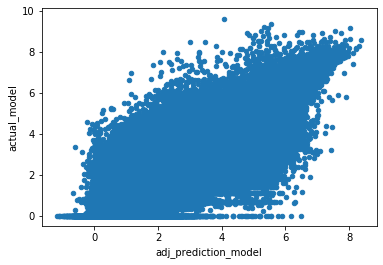

In [ ]:
df_comparison.plot.scatter(x='adj_prediction_model', y='actual_model')

# Visual comparison

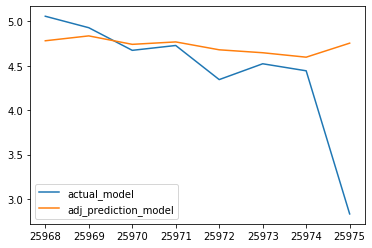

In [ ]:
store_nbr = 3
item_nbr = 105574
df_comparison[
    (df_comparison.store_nbr==store_nbr) &
    (df_comparison.item_nbr==item_nbr)
][["actual_model", "adj_prediction_model"]].plot()

# Error Stats

In [ ]:
df_comparison["AE_model"] = abs(df_comparison["actual_model"] - df_comparison["incumbent_prediction"])
df_comparison["AE_benchmark"] = abs(df_comparison["actual_benchmark"] - df_comparison["adj_prediction_benchmark"])

df_comparison["SE_model"] = (df_comparison["actual_model"] - df_comparison["incumbent_prediction"])**2
df_comparison["SE_benchmark"] = (df_comparison["actual_benchmark"] - df_comparison["adj_prediction_benchmark"])**2

### MAE

In [ ]:
print("model MAE: ", df_comparison["AE_model"].mean())
print("benchmark MAE: ", df_comparison["AE_benchmark"].mean())

model MAE:  0.3662269463761669
benchmark MAE:  24.80519699185326


In [ ]:
print("model MAE: ", df_comparison["AE_model"].std())
print("benchmark MAE: ", df_comparison["AE_benchmark"].std())

model MAE:  0.4417915215921452
benchmark MAE:  90.59255053219785


### RMSE

In [ ]:
print("model RMSE: ", np.sqrt(df_comparison["SE_model"].mean()))
print("benchmark RMSE: ", np.sqrt(df_comparison["SE_benchmark"].mean()))

model RMSE:  0.5738481039667795
benchmark RMSE:  93.92707971841351


In [ ]:
print("model RMSE: ", np.sqrt(df_comparison["SE_model"].std()))
print("benchmark RMSE: ", np.sqrt(df_comparison["SE_benchmark"].std()))

model RMSE:  0.9328412886451944
benchmark RMSE:  774.401142435237


### sMAPE

In [ ]:
_func_model = lambda x: min(abs(x.error_model)/abs(x.actual_model), 1) if x.actual_model != 0 else 0
_func_benchmark = lambda x: min(abs(x.error_benchmark)/abs(x.actual_benchmark), 1) if x.actual_model != 0 else 0

df_comparison["APE_model"] = df_comparison.apply(_func_model, axis=1)
df_comparison["APE_benchmark"] = df_comparison.apply(_func_benchmark, axis=1)

print("model MAPE: ", df_comparison["APE_model"].mean())
print("benchmark MAPE: ", df_comparison["APE_benchmark"].mean())

model MAPE:  0.11830247760118157
benchmark MAPE:  0.3584275481977595


In [ ]:
print("model MAPE: ", df_comparison["APE_model"].std())
print("benchmark MAPE: ", df_comparison["APE_benchmark"].std())

model MAPE:  0.1722440287637635
benchmark MAPE:  0.36801089726645264


### MASE

In [ ]:
def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

In [ ]:
_mase_model = mase(df_comparison["actual_model"].to_numpy(), df_comparison["incumbent_prediction"].to_numpy())
_mase_benchmark = mase(df_comparison["actual_benchmark"].to_numpy(), df_comparison["adj_prediction_benchmark"].to_numpy())

print("model MASE: ", _mase_model)
print("benchmark MASE: ", _mase_benchmark)

model MASE:  0.6500443664458916
benchmark MASE:  1.1680743272373812


# R2

In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true = [3, -0.5, 2, 7], y_pred = [2.5, 0.0, 2, 8])

In [ ]:
# df_aux = df_comparison[(df_comparison['actual_model'] < 1000000)
#                        &
#                        (df_comparison['incumbent_prediction'] > 0)
#                        &
#                        (df_comparison['incumbent_prediction'] < 1000000)]
r2_score(y_true = df_comparison["actual_model"].to_numpy(),
         y_pred = df_comparison["adj_prediction_model"].to_numpy())

0.8564482763178614

In [ ]:
r2_score(y_true = df_comparison["actual_benchmark"].to_numpy(),
         y_pred = df_comparison["adj_prediction_benchmark"].to_numpy())

0.4253338809451992

# Horizon analysis

In [ ]:
df_comparison.groupby("horizon").agg({
    "AE_model": "mean",
    "AE_benchmark": "mean",
    "SE_model": lambda vec: np.sqrt(np.mean(vec)),
    "SE_benchmark": lambda vec: np.sqrt(np.mean(vec)),
    "APE_model": "mean",
    "APE_benchmark": "mean"

})#.to_csv("file.csv", sep=";", decimal=",")

,AE_model,AE_benchmark,SE_model,SE_benchmark,APE_model,APE_benchmark
horizon,,,,,,
1,14.385062,20.145740,52.592869,69.921237,0.246604,0.298366
2,15.689877,21.428856,81.480606,89.559636,0.250740,0.304401
3,16.703410,23.301504,82.438084,102.928536,0.260897,0.331086
4,17.778954,23.501778,80.087342,100.632240,0.269226,0.331804
5,19.469149,24.564648,104.608901,111.932557,0.278338,0.328782
6,20.574662,24.595034,95.398751,107.365251,0.290783,0.301902
7,17.449822,22.833205,70.646420,77.960430,0.277647,0.331777
8,23.391591,38.070811,54.063874,82.542766,0.445807,0.639302


In [ ]:
df_comparison.groupby("horizon").agg({
    "AE_model": "std",
    "AE_benchmark": "std",
    "SE_model": lambda vec: np.sqrt(np.std(vec)),
    "SE_benchmark": lambda vec: np.sqrt(np.std(vec)),
    "APE_model": "std",
    "APE_benchmark": "std"

})

,AE_model,AE_benchmark,SE_model,SE_benchmark,APE_model,APE_benchmark
horizon,,,,,,
1,50.587637,66.956551,491.211230,554.006162,0.256717,0.316553
2,79.956175,86.958719,897.259657,877.535022,0.259272,0.320786
3,80.728608,100.256861,704.285370,871.909809,0.271635,0.341228
4,78.089440,97.850005,548.969203,830.275569,0.276279,0.342924
5,102.781783,109.204448,711.895130,861.161761,0.278451,0.341940
6,93.154195,104.510794,670.833178,842.078149,0.280721,0.320028
7,68.457826,74.542181,497.760019,525.440891,0.286216,0.346509
8,48.741799,73.239217,174.479717,295.839835,0.435626,0.463957


In [ ]:
def calculate_mase(df):
    model = mase(df["actual_model"].to_numpy(), df["incumbent_prediction"].to_numpy())
    baseline = mase(df["actual_benchmark"].to_numpy(), df["adj_prediction_benchmark"].to_numpy())
    return model

df_comparison.groupby("horizon").apply(lambda df: calculate_mase(df))

horizon
1    0.244417
2    0.260718
3    0.294106
4    0.312441
5    0.325131
6    0.325864
7    0.329616
8    1.467583
dtype: float64

In [ ]:
def df_r2(df):
    model_r2 = r2_score(y_true = df["actual_model"].to_numpy(),
                         y_pred = df["adj_prediction_model"].to_numpy())
    benchmark_r2 = r2_score(y_true = df["actual_benchmark"].to_numpy(),
                         y_pred = df["adj_prediction_benchmark"].to_numpy())
    return pd.DataFrame([(model_r2, benchmark_r2)], columns=['model', 'benckmark'])

df_comparison.groupby("horizon").apply(lambda df: df_r2(df))

,,model,benckmark
horizon,,,
1,0,0.893455,0.675650
2,0,0.898645,0.566461
3,0,0.893264,0.380812
4,0,0.892901,0.378707
5,0,0.888109,0.401184
6,0,0.878279,0.405180
7,0,0.888485,0.526270
8,0,0.379715,-3.848980


# Promotions

In [ ]:
df_comparison.groupby("promotion_model").agg({
    "AE_model": "mean",
    "AE_benchmark": "mean",
    "SE_model": lambda vec: np.sqrt(np.mean(vec)),
    "SE_benchmark": lambda vec: np.sqrt(np.mean(vec)),
    "APE_model": "mean",
    "APE_benchmark": "mean"
})

,AE_model,AE_benchmark,SE_model,SE_benchmark,APE_model,APE_benchmark
promotion_model,,,,,,
0.0,13.802580,21.886849,46.076370,65.311445,0.274786,0.355301
1.0,35.204125,36.153850,150.494935,162.917441,0.349189,0.370585


In [ ]:
df_comparison.groupby("promotion_model").agg({
    "AE_model": "std",
    "AE_benchmark": "std",
    "SE_model": lambda vec: np.sqrt(np.std(vec)),
    "SE_benchmark": lambda vec: np.sqrt(np.std(vec)),
    "APE_model": "std",
    "APE_benchmark": "std"
})

,AE_model,AE_benchmark,SE_model,SE_benchmark,APE_model,APE_benchmark
promotion_model,,,,,,
0.0,43.960484,61.535010,381.338978,461.221294,0.311421,0.382264
1.0,146.320006,158.855808,966.824129,1121.469693,0.266435,0.306040


In [ ]:
def df_r2(df):
    model_r2 = r2_score(y_true = df["actual_model"].to_numpy(),
                         y_pred = df["adj_prediction_model"].to_numpy())
    benchmark_r2 = r2_score(y_true = df["actual_benchmark"].to_numpy(),
                         y_pred = df["adj_prediction_benchmark"].to_numpy())
    return pd.DataFrame([(model_r2, benchmark_r2)], columns=['model', 'benckmark'])

df_comparison.groupby("promotion_model").apply(lambda df: df_r2(df))

,,model,benckmark
promotion_model,,,
0.0,0,0.855058,0.404391
1.0,0,0.617280,0.395510


# Diebold-Mariano

In [ ]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of
#   prediction mean squared errors. International Journal of forecasting,
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy,
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True

        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
                from pdb import set_trace
                set_trace()
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual) if actual != 0 else 0)
            e2_lst.append(abs((actual - p2)/actual) if actual != 0 else 0)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return rt

In [ ]:
df_comparison

,actual_model,raw_prediction,adj_prediction_model,horizon,item_nbr,store_nbr,promotion_model,incumbent_prediction,error_model,actual_benchmark,adj_prediction_benchmark,promotion_benchmark,error_benchmark,AE_model,AE_benchmark,SE_model,SE_benchmark,APE_model,APE_benchmark
0,31.363638,7.291278,30.242493,1,105574,1,0.0,30.242493,1.121145,31.363636,31.885929,0,-0.522293,1.121145,0.522293,1.256966,0.272790,0.035747,0.016653
1,47.999995,12.052420,41.609129,2,105574,1,0.0,41.609129,6.390866,48.000000,32.037070,0,15.962930,6.390866,15.962930,40.843169,254.815128,0.133143,0.332561
2,34.000003,6.654623,21.512493,3,105574,1,0.0,21.512493,12.487510,34.000000,32.037070,0,1.962930,12.487510,1.962930,155.937906,3.853093,0.367280,0.057733
3,41.000004,11.128786,32.662665,4,105574,1,0.0,32.662665,8.337338,41.000000,32.037070,0,8.962930,8.337338,8.962930,69.511211,80.334111,0.203350,0.218608
4,35.000002,6.592789,18.714995,5,105574,1,0.0,18.714995,16.285007,35.000000,32.037070,0,2.962930,16.285007,2.962930,265.201442,8.778953,0.465286,0.084655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701131,386.999950,313.038183,311.855632,4,2081064,54,0.0,313.038183,73.961767,387.000000,48.010153,0,338.989847,73.961767,338.989847,5470.343015,114914.116194,0.191116,0.875943
701132,342.999945,372.139642,377.582055,5,2081064,54,0.0,372.139642,-29.139696,343.000000,48.010153,0,294.989847,29.139696,294.989847,849.121910,87019.009681,0.084955,0.860029
701133,402.000037,346.188817,348.277394,6,2081064,54,0.0,348.277394,53.722643,402.000000,48.010153,0,353.989847,53.722643,353.989847,2886.122326,125308.811596,0.133638,0.880572
701134,381.000051,320.438478,325.553803,7,2081064,54,0.0,325.553803,55.446248,381.000000,48.010153,0,332.989847,55.446248,332.989847,3074.286397,110882.238033,0.145528,0.873989


In [ ]:
recs = []

for h in range(1, 9):
    df_local = df_comparison[df_comparison.horizon <= h]
    print(h)
    for measure in ["MAD", "MSE", "MAPE"]:
        print(measure)
        rt = dm_test(
            df_local["actual_model"].astype(int).tolist(),
            df_local["incumbent_prediction"].astype(int).tolist(),
            df_local["adj_prediction_benchmark"].astype(int).tolist(),
            h = h,
            crit=measure
        )
        recs.append({
            "measure": measure,
            "h": h,
            "DM_stat": rt.DM,
            "p_value": rt.p_value
        })

df_diebold_mariano = pd.DataFrame(recs)

1
MAD
MSE
MAPE
2
MAD
MSE
MAPE
3
MAD
MSE
MAPE
4
MAD
MSE
MAPE
5
MAD
MSE
MAPE
6
MAD
MSE
MAPE
7
MAD
MSE
MAPE
8
MAD
MSE
MAPE


In [ ]:
df_diebold_mariano.pivot_table(values=["DM_stat", "p_value"],
                               index="h", columns="measure")#.to_csv("DM_test.csv", sep=";", decimal=",")

DM_stat                             p_value                 \
measure        MAD       MAPE       MSE            MAD           MAPE   
h                                                                       
1       -33.375255 -27.344715 -3.364540  1.054722e-242  6.120872e-164   
2       -36.198460 -35.311544 -4.017606  7.388639e-286  3.562146e-272   
3       -36.513542 -40.179825 -3.137259  3.653306e-291   0.000000e+00   
4       -34.259830 -34.390143 -2.594331  8.312073e-257  9.593530e-259   
5       -32.886541 -38.164431 -2.048276  6.672990e-237   0.000000e+00   
6       -29.577997 -37.234322 -1.848734  4.127674e-192  4.738380e-303   
7       -31.045724 -39.548081 -1.969019  1.903402e-211   0.000000e+00   
8       -41.782263 -66.964924 -2.441634   0.000000e+00   0.000000e+00   

                   
measure       MSE  
h                  
1        0.000767  
2        0.000059  
3        0.001706  
4        0.009478  
5        0.040534  
6        0.064497  
7        0.048951  
8        0.014621

# Cool Viz

In [ ]:
df_product_categories = pd.read_csv("../data/favorita-grocery-sales-forecasting/items.csv")
df_store_categories = pd.read_csv("../data/favorita-grocery-sales-forecasting/stores.csv")

In [ ]:
df_comparison.columns

Index(['actual_model', 'raw_prediction', 'adj_prediction_model', 'horizon',
       'item_nbr', 'store_nbr', 'promotion_model', 'incumbent_prediction',
       'error_model', 'actual_benchmark', 'adj_prediction_benchmark',
       'promotion_benchmark', 'error_benchmark', 'AE_model', 'AE_benchmark',
       'SE_model', 'SE_benchmark', 'APE_model', 'APE_benchmark'],
      dtype='object')

In [ ]:
df_comparison_full = df_comparison.merge(df_product_categories, on=["item_nbr"]).merge(df_store_categories, on=["store_nbr"])

# Error per family

In [ ]:
df_sales_per_family = df_comparison_full.groupby("family").agg({"actual_model":"sum"}).sort_values(by="actual_model", ascending=False)
df_sales_per_family["percentage_in_sales"] = df_sales_per_family["actual_model"].cumsum()/df_sales_per_family["actual_model"].sum()
list_of_families = df_sales_per_family[df_sales_per_family["percentage_in_sales"] < 0.95].index.tolist()

In [ ]:
df_sales_per_family

,actual_model,percentage_in_sales
family,,
GROCERY I,9.109374e+06,0.283979
BEVERAGES,7.578379e+06,0.520231
PRODUCE,5.610610e+06,0.695139
CLEANING,2.572181e+06,0.775325
DAIRY,1.567278e+06,0.824184
BREAD/BAKERY,1.150735e+06,0.860057
POULTRY,9.856067e+05,0.890783
MEATS,8.516726e+05,0.917333
PERSONAL CARE,5.783719e+05,0.935364


In [ ]:
df_comparison_full.head()

,actual_model,raw_prediction,adj_prediction_model,horizon,item_nbr,store_nbr,promotion_model,incumbent_prediction,error_model,actual_benchmark,...,SE_benchmark,APE_model,APE_benchmark,family,class,perishable,city,state,type,cluster
0,31.363638,7.291278,30.242493,1,105574,1,0.0,30.242493,1.121145,31.363636,...,0.272790,0.035747,0.016653,GROCERY I,1045,0,Quito,Pichincha,D,13
1,47.999995,12.052420,41.609129,2,105574,1,0.0,41.609129,6.390866,48.000000,...,254.815128,0.133143,0.332561,GROCERY I,1045,0,Quito,Pichincha,D,13
2,34.000003,6.654623,21.512493,3,105574,1,0.0,21.512493,12.487510,34.000000,...,3.853093,0.367280,0.057733,GROCERY I,1045,0,Quito,Pichincha,D,13
3,41.000004,11.128786,32.662665,4,105574,1,0.0,32.662665,8.337338,41.000000,...,80.334111,0.203350,0.218608,GROCERY I,1045,0,Quito,Pichincha,D,13
4,35.000002,6.592789,18.714995,5,105574,1,0.0,18.714995,16.285007,35.000000,...,8.778953,0.465286,0.084655,GROCERY I,1045,0,Quito,Pichincha,D,13


In [ ]:
df_aux = df_comparison_full[df_comparison_full.family.isin(list_of_families)]

df_1 = df_aux[["AE_model", "family"]].rename(columns={"AE_model": "Absolute Error (units)"})
df_2 = df_aux[["AE_benchmark", "family"]].rename(columns={"AE_benchmark": "Absolute Error (units)"})

df_1["Model"] = "xgBoostModel"
df_2["Model"] = "Base-Lift"

df_aux = pd.concat([df_1, df_2], axis=0)

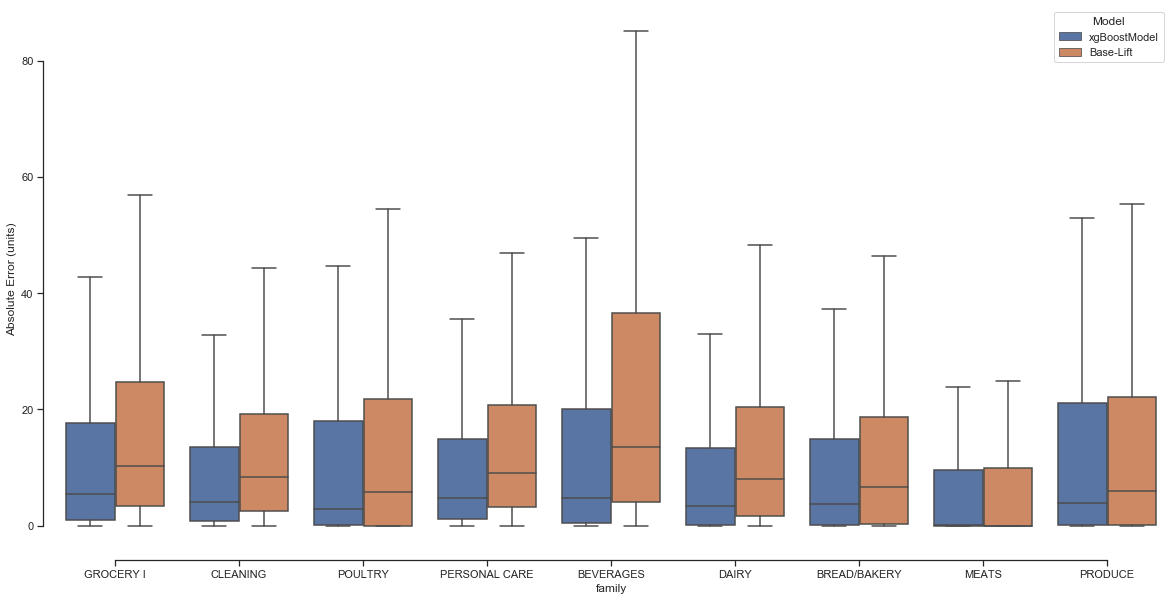

In [ ]:
sns.set(style="ticks")

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)

sns.boxplot(data=df_aux, x="family", y="Absolute Error (units)", hue="Model", showfliers=False, ax=ax)

sns.despine(offset=10, trim=True)

# Error per cluster

In [ ]:
df_comparison_full

,actual_model,raw_prediction,adj_prediction_model,horizon,item_nbr,store_nbr,promotion_model,incumbent_prediction,error_model,actual_benchmark,...,SE_benchmark,APE_model,APE_benchmark,family,class,perishable,city,state,type,cluster
0,31.363638,7.291278,30.242493,1,105574,1,0.0,30.242493,1.121145,31.363636,...,0.272790,0.035747,0.016653,GROCERY I,1045,0,Quito,Pichincha,D,13
1,47.999995,12.052420,41.609129,2,105574,1,0.0,41.609129,6.390866,48.000000,...,254.815128,0.133143,0.332561,GROCERY I,1045,0,Quito,Pichincha,D,13
2,34.000003,6.654623,21.512493,3,105574,1,0.0,21.512493,12.487510,34.000000,...,3.853093,0.367280,0.057733,GROCERY I,1045,0,Quito,Pichincha,D,13
3,41.000004,11.128786,32.662665,4,105574,1,0.0,32.662665,8.337338,41.000000,...,80.334111,0.203350,0.218608,GROCERY I,1045,0,Quito,Pichincha,D,13
4,35.000002,6.592789,18.714995,5,105574,1,0.0,18.714995,16.285007,35.000000,...,8.778953,0.465286,0.084655,GROCERY I,1045,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701131,386.999950,313.038183,311.855632,4,2081064,54,0.0,313.038183,73.961767,387.000000,...,114914.116194,0.191116,0.875943,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3
701132,342.999945,372.139642,377.582055,5,2081064,54,0.0,372.139642,-29.139696,343.000000,...,87019.009681,0.084955,0.860029,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3
701133,402.000037,346.188817,348.277394,6,2081064,54,0.0,348.277394,53.722643,402.000000,...,125308.811596,0.133638,0.880572,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3
701134,381.000051,320.438478,325.553803,7,2081064,54,0.0,325.553803,55.446248,381.000000,...,110882.238033,0.145528,0.873989,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3


In [ ]:
df_aux = df_comparison_full

df_1 = df_aux[["AE_model", "type"]].rename(columns={"AE_model": "Absolute Error (units)"})
df_2 = df_aux[["AE_benchmark", "type"]].rename(columns={"AE_benchmark": "Absolute Error (units)"})

df_1["Model"] = "xgBoostModel"
df_2["Model"] = "Base-Lift"

df_aux = pd.concat([df_1, df_2], axis=0)

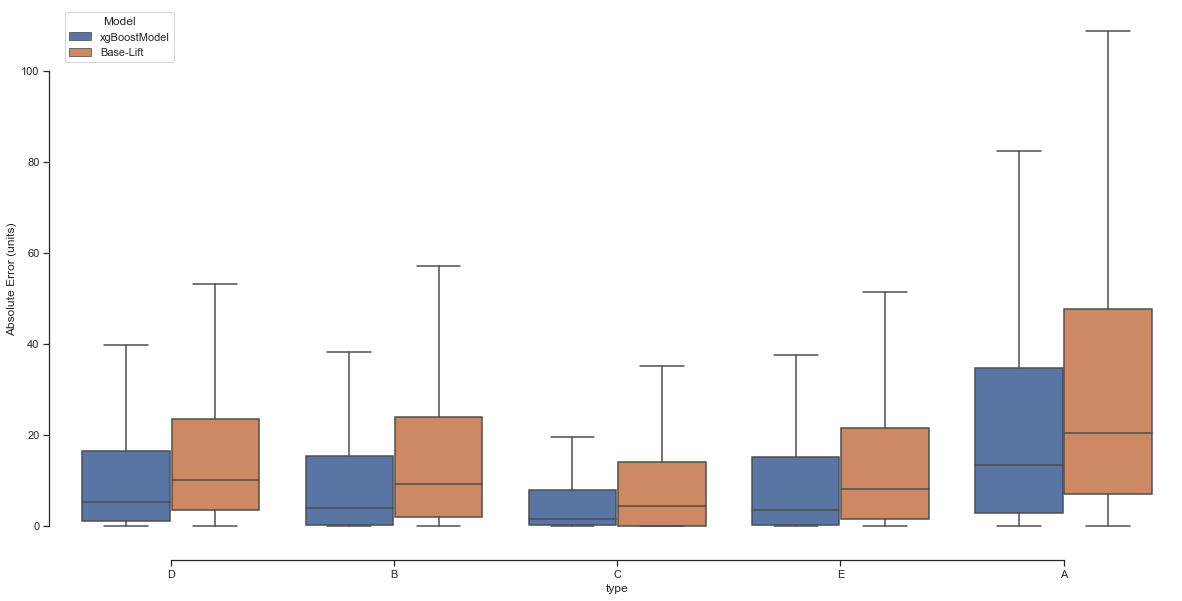

In [ ]:
sns.set(style="ticks")

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)

sns.boxplot(data=df_aux, x="type", y="Absolute Error (units)", hue="Model", showfliers=False, ax=ax)

sns.despine(offset=10, trim=True)